## Time series analysis forecasting for tire product

produced by Colin Shu
--9/8/2019

&nbsp;&nbsp;GoodTires.com is an online retailer, selling replacement tires for autos and light trucks. The company is interested in constructing a short-term sales forecasting method for this product. The forecast will be used to make one-week-ahead forecasts so that they can make ordering decisions from the tire manufacturer for the following week. <br>
&nbsp;&nbsp;For a basic time series forecasting, I tried two different models – a 3-week weighted moving average and single exponential smoothing – to forecast this product’s sales. The parameters are estimated for each type of model (to minimize MSE), using the data from the first three quarters of the year (39 observations), the other data are used for model validation (13 observations). The CFE, MAD and MAPE measures are computed on the remaining 13 observations (the last quarter of the year) and each model is evaluated.

In [63]:
# import basic libraries
import pandas as pd
import numpy as np
from random import random

# import libraries for visualization
import matplotlib as plt
import seaborn as sns

Import the data set and clean the data

In [30]:
# import the data
data = pd.read_excel("CEE 5930 Assignment 1 Data -- Fall 2019.xlsx", sheetname='GoodTires Data')
data.head()

,Weekly Sales,Unnamed: 1
0,Week,Units Sold
1,1,287
2,2,290
3,3,268
4,4,270


In [31]:
data.columns = list(data.iloc[0].values)
df = data.drop(data.index[0])

In [32]:
# make sure the rows are 52 in total
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52 entries, 1 to 52
Data columns (total 2 columns):
Week          52 non-null object
Units Sold    52 non-null object
dtypes: object(2)
memory usage: 1.2+ KB


In [33]:
df.index = df['Week']

In [35]:
df = df['Units Sold']

In [37]:
df.head()

Week
1    287
2    290
3    268
4    270
5    262
Name: Units Sold, dtype: object

A quick visualization of the time series data

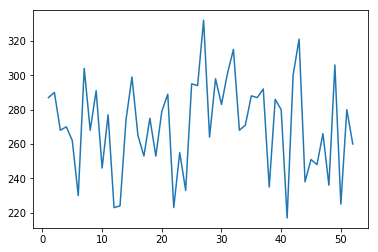

In [56]:
# fig, ax = plt.subplots(figsize=(8,6))
sns.lineplot(x=list(df.index), y=list(df.values))

&nbsp;&nbsp;To forecast the next week product sales, the first 3/4 data is used, for two kinds of models, to find the appropriate the parameters which minimize the MSE value. Then the last 1/4 data is used to evaluate the two models, comparing the different measures (CFE, MAD and MAPE).

###  A 3-week weighted moving average model

Before calculate the moving average forecasting, the parameters of the three parameters need to be generated

In [78]:
# generate three weighted parameters with the fixed sum of 1
def generate_groups_of_params(groups=10):
    groups_of_params = []
    for i in range(groups):
        w1 = random()
        w2 = (1-w1)*random()
        w3 = 1-w1-w2
        groups_of_params.append((w1,w2,w3))
    return groups_of_params

In [85]:
params = list(set(generate_groups_of_params(groups=1000)))

In [130]:
params[0]

(0.8389296523761874, 0.07631492895888582, 0.08475541866492674)

In [112]:
params.append((0.1, 0.2, 0.7))
# check the final parameter set size
len(params)

In [125]:
# calculate each moving average forecasting using each parameter group (among the 1001)
def moving_average_forecasting(data,
                               useful_history=3, 
                               parameters=params,
                               observation_for_model_training=39
                               ):
    forecast_results = []
    for params in parameters:
        forecast_result = []
        for idx,value in enumerate(data):
            if idx <= useful_history-1:
                forecast_result.append(value)
            else:
                wt_3_week_ago = data[idx-useful_history]
                wt_2_week_ago = data[idx-useful_history+1]
                wt_1_week_ago = data[idx-useful_history+2]
                forecast = wt_3_week_ago*params[0] + wt_2_week_ago*params[1] + wt_1_week_ago*params[2]
                forecast_result.append(forecast)
        forecast_result = forecast_result[0:observation_for_model_training-1]
        forecast_results.append(forecast_result)
    return forecast_results

In [126]:
forecast_results = moving_average_forecasting(list(df.values), 
                                              useful_history=2, 
                                              parameters=params,
                                              observation_for_model_training=39)

In [127]:
len(forecast_results)

1001

In [128]:
forecast_results[0]

[287,
 290,
 285.61859183224306,
 286.62596318960595,
 267.64409734592823,
 265.99926382173186,
 263.11764985724255,
 238.86801065222477,
 300.15084211483605,
 267.890624155426,
 286.37925233554114,
 246.41638816843215,
 268.38695664697906,
 227.39884128087013,
 234.1724028478138,
 275.1450744559878,
 292.50654315681123,
 264.9317750391426,
 254.67892843709546,
 273.66009323756424,
 258.0353832248684,
 275.01684584435293,
 281.08153045410603,
 226.2896319133336,
 256.7112883095016,
 242.90160613401147,
 298.0596355616434,
 294.3573047404899,
 323.9289005961882,
 268.2050605392357,
 297.1095423216115,
 287.0858421185376,
 299.27148018948185,
 307.68395991767557,
 269.92405316017516,
 273.6534404909399,
 288.2627067457008,
 282.97429287421824]

After using all the 1001 parameters, I calculated the prediction for the 36 (39-3) sales, as shown above. Then, I can calculate the MSE (mean squared error), which is considered as the objective function to be minimize to find out the best parameters for this 3-week moving average model.

In [146]:
def best_params_set_which_minimizes_MSE(actual_value,
                                        forecast_results):
    # initiate the MSE and best parameters
    MSE = sum((np.array(forecast_results[0]) - np.array(list(df.values)[0:38]))**2)
    best_params = (0.1, 0.2, 0.7)
    for param, forecast_result in zip(params,forecast_results):
        new_MSE = sum((np.array(forecast_result) - np.array(list(df.values)[0:38]))**2)
        if new_MSE < MSE:
            MSE = new_MSE
            best_params = param
    return (best_params, MSE)

In [147]:
best_params = best_params_set_which_minimizes_MSE(list(df.values), forecast_results)

In [148]:
best_params

((0.005040220405816198, 0.08334368216063984, 0.911616097433544),
 328.79285174849184)